In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/patrones_personal")

In [ ]:
!pip install pydicom
!pip install keras
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.3 MB/s eta 0:00:00


# Challenge 8

Se utilizó la base de datos de Physionet: "VinDr-SpineXR: A large annotated medical image dataset for spinal lesions detection and classification from radiographs"

**Base de datos:**

Pham, H. H., Nguyen Trung, H., & Nguyen, H. Q. (2021). VinDr-SpineXR: A large annotated medical image dataset for spinal lesions detection and classification from radiographs (version 1.0.0). PhysioNet. https://doi.org/10.13026/q45h-5h59.

**Publicación original:**

Nguyen, H. T., Pham, H. H., Nguyen, N. T., Nguyen, H. Q., Huynh, T. Q., Dao, M., & Vu, V. (2021). VinDr-SpineXR: A deep learning framework for spinal lesions detection and classification from radiographs. ArXiv (Cornell University). https://doi.org/10.48550/arxiv.2106.12930

**Physionet:**

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

## Exploración de los datos

Se cargó el csv con datos de los ids de las imágenes así como el tipo de lesión de cada una de ellas

In [ ]:
import pandas as pd


file_path = './annotations/train.csv'
data = pd.read_csv(file_path)

data.head()


,study_id,series_id,image_id,rad_id,lesion_type,xmin,ymin,xmax,ymax
0,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,712.636842,961.361404,786.587719,1011.782456
1,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,789.949123,1452.126316,880.707018,1505.908772
2,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,692.468421,655.473684,746.250877,709.256140
3,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,820.201754,1603.389474,910.959649,1670.617544
4,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,739.528070,1203.382456,820.201754,1240.357895


## Extracción de labels e ids

Se escogieron 100 ids de imágenes con implantes y 100 ids de imágenes sin implantes

In [ ]:

lesion_counts = data[data['lesion_type'] != 'Other lesions']['lesion_type'].value_counts()
labels = ["Surgical implant", "No finding"]

labels_dict = {}

sample_ids = []
for lesion in labels:
    lesion_data = data[data['lesion_type'] == lesion]
    data_ids = lesion_data['image_id'].drop_duplicates().sample(n=100, random_state=1).tolist()


    sample_ids.extend(data_ids)
    labels_dict[lesion] = data_ids



# Append the ".dicom" extension to each image_id
sample_ids_dcm = [f"{id}.dicom" for id in sample_ids]

# Return the final list of DICOM file names and the top 5 lesions
labels, sample_ids_dcm[:10], len(sample_ids_dcm)


(['Surgical implant', 'No finding'],
 ['f150dbacd86dcea7620d49c93b7bfa12.dicom',
  '056a5808b0ce5bc9e18cb35a22f409b5.dicom',
  '57fcfdcfb7a5e3a28caf2e755c9da5bd.dicom',
  '9636564324cec881b61581887d30506e.dicom',
  'ed2d75e7cf2c5faf621b308525a41553.dicom',
  '21f15126067faf345da00a3282735823.dicom',
  '3fc35e5d71e80b02b733da70b73d2947.dicom',
  '5395d3799d1f4471087a173bff4a5afa.dicom',
  'a3bd71fa3964605e523f017cdebe8e9d.dicom',
  '4efb58ed7458f650d1affef27951bc88.dicom'],
 200)

In [ ]:
len(labels_dict["Surgical implant"])

100

## Ejemplo de ploteo de imagen

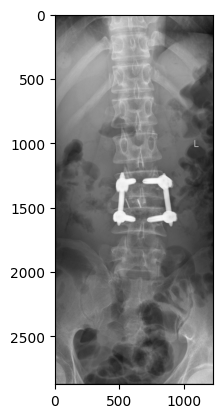

(2874, 1232)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom


# Cargar el archivo DICOM
dicom_path = f'./train_images/{labels_dict["Surgical implant"][26]}.dicom'
dicom_file = pydicom.dcmread(dicom_path)

# Extraer la imagen del archivo DICOM
image_data = dicom_file.pixel_array
fig, ax = plt.subplots(1)
# Mostrar la imagen

ax.imshow(image_data, cmap='gray')
#rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

# Añadir el rectángulo al plot
#ax.add_patch(rect)

plt.show()
image_data.shape



## Carga de las imágenes seleccionadas

Se cargaron las imágenes según los ids elegidos anteriormente, se redimensionaron las imágenes para que todas tengan el mismo tamaño.

In [ ]:
import os
import pydicom
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_dicom_images(directory, sample_ids):
    image_dimensions = []
    image_files = []
    for filename in sample_ids:
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path) and filename.endswith(".dicom"):
            dicom_img = pydicom.dcmread(file_path)
            rows, cols = dicom_img.pixel_array.shape
            image_dimensions.append((rows, cols))
            image_files.append(dicom_img)
    return image_files, image_dimensions

def find_common_aspect_ratio(dimensions):
    aspect_ratios = [dim[1] / dim[0] for dim in dimensions]
    mean_aspect_ratio = np.mean(aspect_ratios)
    return mean_aspect_ratio

def resize_images(images, target_height, target_aspect_ratio):
    resized_images = []
    for image in images:
        target_width = int(target_height * target_aspect_ratio)
        new_image = resize(image.pixel_array, (target_height, target_width), anti_aliasing=True)
        resized_images.append(new_image)
    return resized_images


directory = './train_images/'


images, dimensions = load_dicom_images(directory, sample_ids_dcm)
common_aspect_ratio = find_common_aspect_ratio(dimensions)
target_height = 512
resized_images = resize_images(images, target_height, common_aspect_ratio)

# Optionally display
plt.imshow(resized_images[101], cmap='gray')
plt.show()


/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import pickle
with open('resized_imgs_implants_512.pkl', 'wb') as file:
    pickle.dump(resized_images, file)

In [ ]:
with open('resized_imgs_implants_512.pkl', 'rb') as file:
    resized_images = pickle.load(file)


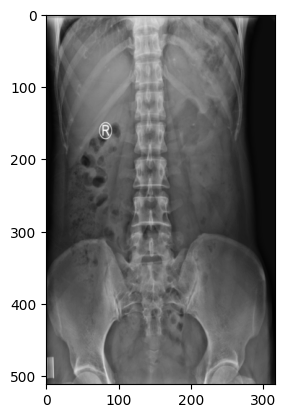

In [ ]:
plt.imshow(resized_images[151], cmap='gray')
plt.show()

Asignación de labels

In [ ]:
id_to_label = {image_id: lesion_type for lesion_type, ids in labels_dict.items() for image_id in ids}

# Extraer las etiquetas correspondientes para cada ID de imagen con extensión .dicom
sample_ids_dcm = [f"{id}.dicom" for id in id_to_label.keys()]
labels2 = [id_to_label[id.replace('.dicom', '')] for id in sample_ids_dcm]

In [ ]:
labels2

['Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical implant',
 'Surgical im

## Split del dataset

Se dividió el dataset en entrenamiento, test y validación usando la distribución 80-10-10.

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Codificar las etiquetas a un formato numérico
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels2)  # Codificación directa a etiquetas binarias

resized_images_np = np.array(resized_images)
# Dividir los datos en entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(resized_images_np, integer_encoded, test_size=0.05, random_state=31, stratify=integer_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.053, random_state=31, stratify=y_train)  # 0.111 * 0.90 = 0.10
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Ejemplo para verificar las etiquetas codificadas
print("Ejemplo de etiquetas codificadas:", y_train[:5])


X_train shape: (179, 512, 317)
y_train shape: (179,)
X_val shape: (11, 512, 317)
y_val shape: (11,)
X_test shape: (10, 512, 317)
y_test shape: (10,)
Ejemplo de etiquetas codificadas: [1 1 0 0 1]


## Diseño de un modelo con CNN

Se aplicó dropout para simplificar el modelo y se introdujo regularización L2 con el fin de reducir el overfitting y mejorar los resultados.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

def create_regularized_model(input_shape):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Dimensiones de entrada basadas en las imágenes procesadas
input_shape = (512, 317, 1)  # Asumiendo que las imágenes son en escala de grises

# Crear el modelo
model = create_regularized_model(input_shape)

# Resumen del modelo
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 512, 317, 16)      160       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 256, 158, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 256, 158, 32)      4640      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 128, 79, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 323584)            0         
                                                                 
 dense_21 (Dense)            (None, 64)              

## Entrenamiento del modelo revisado

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Asume que ya tienes un modelo llamado 'model'
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)]
)


Epoch 1/300
3/3 [==============================] - 2s 325ms/step - loss: 2.5241 - accuracy: 0.5028 - val_loss: 1.2560 - val_accuracy: 0.4545
Epoch 2/300
3/3 [==============================] - 0s 126ms/step - loss: 1.4520 - accuracy: 0.5698 - val_loss: 1.2940 - val_accuracy: 0.3636
Epoch 3/300
3/3 [==============================] - 0s 132ms/step - loss: 1.4320 - accuracy: 0.5363 - val_loss: 1.3151 - val_accuracy: 0.3636
Epoch 4/300
3/3 [==============================] - 0s 178ms/step - loss: 1.2849 - accuracy: 0.6369 - val_loss: 1.2191 - val_accuracy: 0.4545
Epoch 5/300
3/3 [==============================] - 0s 177ms/step - loss: 1.1731 - accuracy: 0.6480 - val_loss: 1.1462 - val_accuracy: 0.3636
Epoch 6/300
3/3 [==============================] - 0s 181ms/step - loss: 1.1012 - accuracy: 0.6201 - val_loss: 1.1374 - val_accuracy: 0.3636
Epoch 7/300
3/3 [==============================] - 0s 175ms/step - loss: 1.0402 - accuracy: 0.6704 - val_loss: 1.1147 - val_accuracy: 0.4545
Epoch 8/300
3

## Verificación de resultado

Se obtuvo un mejor accuracy y se redujeron significativamente las diferencias entre la pérdida de validación y de entrenamiento, reduciendo el overfitting con éxito.

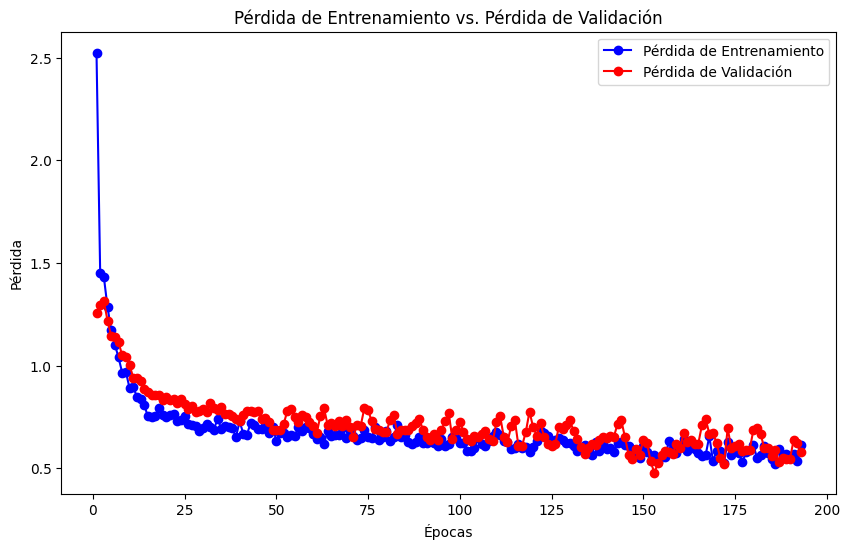

In [ ]:
import matplotlib.pyplot as plt

# Extraer los valores de pérdida de entrenamiento y validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un rango de épocas para el eje X
epochs = range(1, len(train_loss) + 1)

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, 'ro-', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento vs. Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)


1/1 - 0s - loss: 0.6822 - accuracy: 0.8000 - 30ms/epoch - 30ms/step

Test accuracy: 0.800000011920929


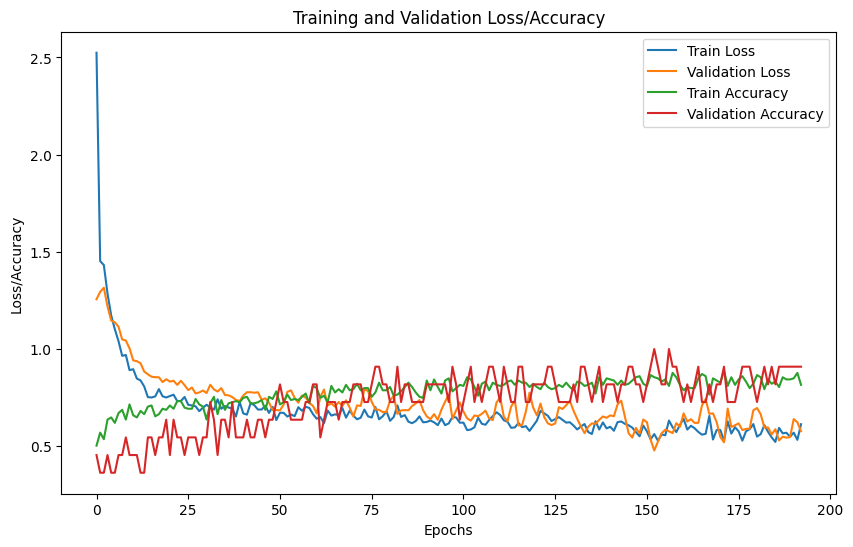

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss/Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


In [ ]:
model.save('model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


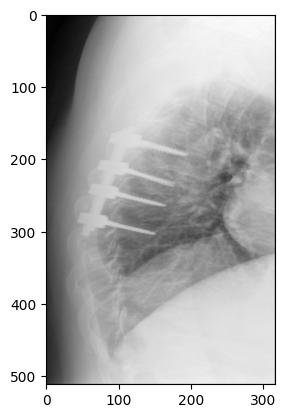

1/1 [==============================] - 0s 85ms/step
[0.6962932]


In [ ]:
i = 4
plt.imshow(X_test[i], cmap='gray')
plt.show()
preds = model.predict(X_test)
print(preds[i])